# Game Recommendation - Model Creation
Creates and saves TF-IDF matrix and DataFrame for use in recommendation script

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
# Load dataset
df = pd.read_csv('datasets/steam-games-cleaned.csv')
df['genres'] = df['genres'].fillna('')
df['tags'] = df['tags'].fillna('')
df = df.reset_index(drop=True)

print(f'Dataset size: {len(df)}')

Dataset size: 42410


In [3]:
# Weighted tags function - first tags are more important
def create_weighted_tags(tags_str, decay_factor=0.8):
    if pd.isna(tags_str) or tags_str == '':
        return ''
    tags = [t.strip() for t in tags_str.split(',')]
    weighted_tags = []
    for i, tag in enumerate(tags):
        weight = decay_factor ** i
        repetitions = max(1, int(weight * 5))
        weighted_tags.extend([tag] * repetitions)
    return ' '.join(weighted_tags)

# Create features
df['weighted_tags'] = df['tags'].apply(create_weighted_tags)
df['features'] = df['genres'].str.replace('_', ' ') + ' ' + df['weighted_tags']

In [4]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=100, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['features'])

print(f'TF-IDF matrix shape: {tfidf_matrix.shape}')

TF-IDF matrix shape: (42410, 100)


## Visualization with K-Means Clustering

In [5]:
# K-Means Clustering (K=6)
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

# Analyze Cluster Distribution
print(df['cluster'].value_counts().sort_index())

cluster
0     6003
1     3030
2     2091
3    17463
4     8841
5     4982
Name: count, dtype: int64


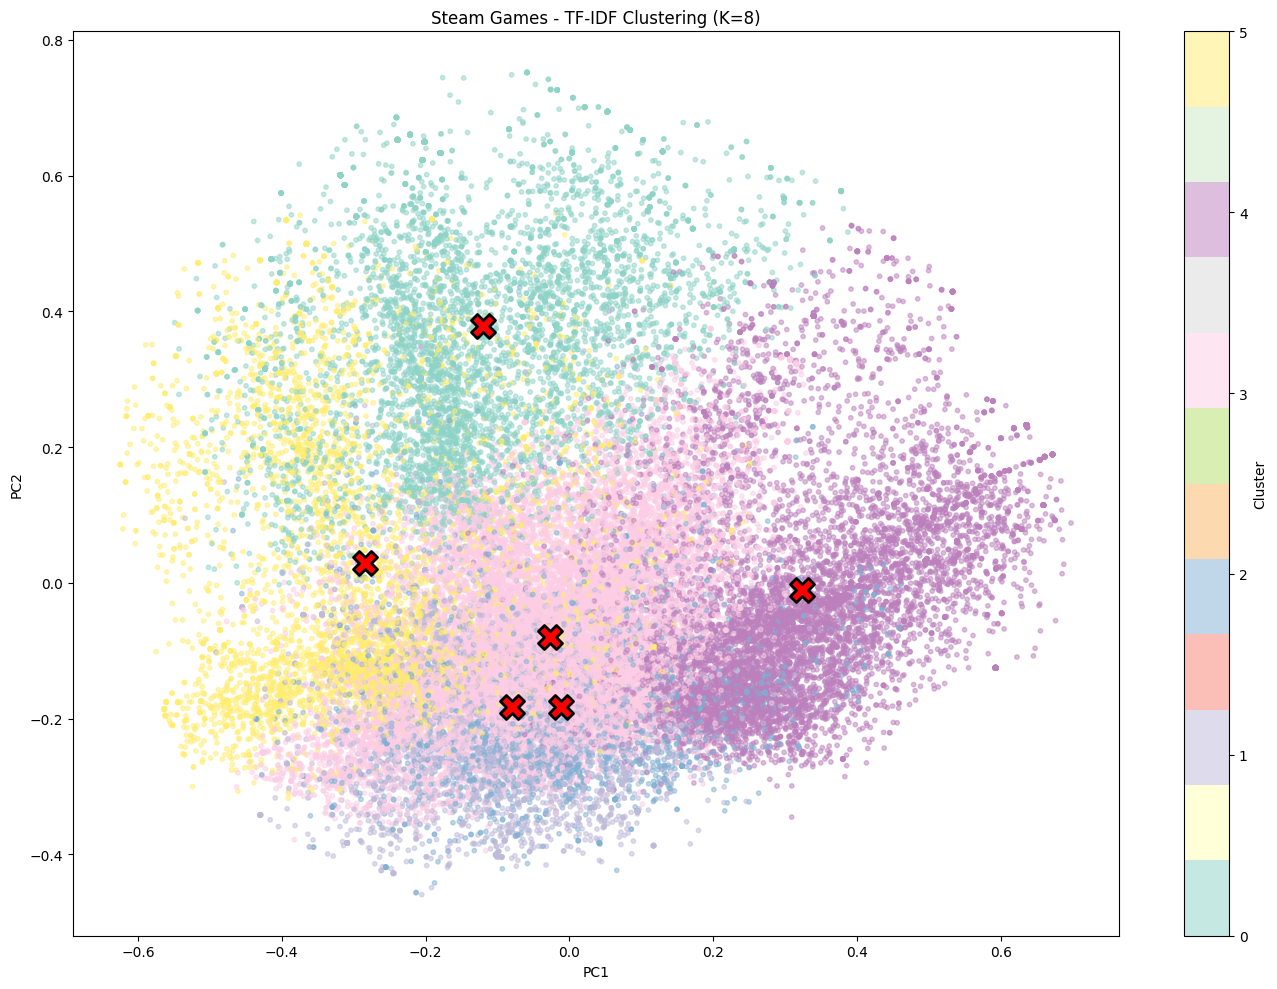

In [ ]:
# PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(14, 10))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df['cluster'], cmap='Set3', alpha=0.5, s=10)

# Plot cluster centers
centers_2d = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='red', marker='X', s=300, edgecolors='black', linewidths=2)

plt.colorbar(scatter, label='Cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Steam Games - TF-IDF Clustering (K=6)')
plt.tight_layout()
plt.show()

## Save Model

In [7]:
# Save Model with Enhanced Metadata

# 1. Handle Review Counts for Popularity Logic
if 'total_reviews' not in df.columns:
    # Try to find a review count column
    candidates = ['reviews_count', 'all_reviews', 'review_count']
    found = False
    for col in candidates:
        if col in df.columns:
            df['total_reviews'] = df[col]
            print(f"Mapped '{col}' to 'total_reviews'")
            found = True
            break
    if not found:
        print("Warning: No review count column found. Defaulting to 0.")
        df['total_reviews'] = 0

# 2. Select Columns
cols = ['app_id', 'title', 'genres', 'tags', 'review_score', 'total_reviews', 'cluster']
df_clean = df[cols].copy()

# 3. Save Package
model_data = {
    'dataframe': df_clean,
    'matrix': tfidf_matrix,
    'vectorizer': tfidf
}

with open('models/steam_recommender.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print('Model saved to models/steam_recommender.pkl')

Mapped 'review_count' to 'total_reviews'
Model saved to models/steam_recommender.pkl
